# Workshop3: Fine-tuning Mistral Small 24B with QLoRA

Welcome to this hands-on workshop! By the end of this session, you'll have fine-tuned a Mistral Small 24B model for medical diagnosis and deployed it as a custom model in Amazon Bedrock.

### What You'll Learn:
- Fine-tuning large language models with QLoRA (Quantized LoRA)
- Working with medical datasets for AI training
- Preparing models for Amazon Bedrock Custom Model Import
- Comparing base vs fine-tuned model performance


## Workshop Overview:
1. **Environment Setup** - Install dependencies and configure environment
2. **Data Preparation** - Load and prepare medical training data
3. **Model Loading** - Load quantized Mistral Small 24B model
4. **QLoRA Configuration** - Set up efficient fine-tuning adapters
5. **Training** - Fine-tune the model on medical data
6. **Evaluation** - Compare base vs fine-tuned performance
7. **Custom Model Import to Bedrock** - Prepare for Bedrock deployment

<img src="images/QLoRA_process.png" width="600px" alt="QLoRA_process">

<mark>Note: We don't fine-tune the model during the workshop. If you want to fine-tune the model later offline, recommended configurations are:</mark>
- **Instance Type**: `ml.g5.48xlarge` or similar (8 A10G GPUs, 24GB GPU memory each)
- **Alternative**: `ml.g6.16xlarge` (1 NVIDIA L4 GPUs, 24 GB GPU memory) 
- **Environment**: SageMaker Studio with Python 3 kernel

## Step 1: Environment Setup & Prerequisites

Let's start by setting up our environment and understanding our tools:

### Dataset Information:
We'll use the **BI55/MedText** dataset, which contains medical prompts and completions for training a medical AI assistant.

### Hugging Face Setup:
1. Get access to [Mistral Small 24B Instruct](https://huggingface.co/mistralai/Mistral-Small-24B-Instruct-2501)
2. Create a [Hugging Face API token](https://huggingface.co/docs/hub/en/security-tokens) with READ permissions
3. Login using `notebook_login()`

In [1]:
from huggingface_hub import notebook_login

notebook_login()

‼️ Mistral Small 3 is a gated model. Please accept the terms to access the model from here: https://huggingface.co/mistralai/Mistral-Small-24B-Instruct-2501 

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Install Required Libraries

In [ ]:
# !pip3 install -qU accelerate>=1.6.0
# !pip3 install -qU torch bitsandbytes transformers==4.46.3 peft datasets
# !pip3 install -qU tensorboardX

In [3]:
# Add installed cuda runtime to path for bitsandbytes 
import nvidia
import os

cuda_install_dir = '/'.join(nvidia.__file__.split('/')[:-1]) + '/cuda_runtime/lib/'
os.environ['LD_LIBRARY_PATH'] =  cuda_install_dir

## Step 2: Load and Prepare Medical Dataset

In [5]:
# Load the medical dataset and split into train/validation/test sets
from datasets import load_dataset
import torch

print("🏥 Loading medical dataset...")
dataset = load_dataset("BI55/MedText", split="train")

# Split into 80% train, 10% validation, 10% test
split_1 = dataset.train_test_split(test_size=0.2, seed=42)
split_2 = split_1['test'].train_test_split(test_size=0.5, seed=42)

train_set = split_1['train']
validation_set = split_2['train']
test_set = split_2['test']

print(f"✅ Dataset loaded successfully!")

🏥 Loading medical dataset...
✅ Dataset loaded successfully!


In [6]:
# Let's examine our dataset structure
print("🔍 Dataset structure:")
print(f"   Features: {train_set.features}")
print(f"\n📋 Sample data point:")
print(f"   Prompt: {train_set[0]['Prompt']}")
print(f"   Completion: {train_set[0]['Completion']}")

🔍 Dataset structure:
   Features: {'Prompt': Value(dtype='string', id=None), 'Completion': Value(dtype='string', id=None)}

📋 Sample data point:
   Prompt: A 16-year-old male presents with multiple blackheads and red bumps on his forehead, cheeks, and nose. He mentions they have been persisting for about a year, and he feels his skin is quite oily. What could be the potential cause, and what would be the treatment plan?
   Completion: This patient is likely suffering from moderate acne vulgaris, characterized by a mix of open comedones (blackheads) and inflammatory lesions (red bumps). Acne vulgaris is common during adolescence due to increased sebum production, prompted by hormonal changes. The first line of treatment includes topical retinoids, which help unclog pores, and topical antimicrobials such as benzoyl peroxide or clindamycin to reduce bacterial growth and inflammation.


## Step 3: Load Quantized Mistral Small 24B Model

In [7]:

# Load the quantized model with 4-bit precision for efficient training
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

print("🚀 Loading Mistral Small 24B model...")
model_id = "mistralai/Mistral-Small-24B-Instruct-2501"

# Configure 4-bit quantization for memory efficiency
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model with quantization
model = AutoModelForCausalLM.from_pretrained(
    model_id, 
    quantization_config=bnb_config, 
    device_map="auto", 
    cache_dir="/mnt/sagemaker-nvme"  # Use NVMe storage for caching
)

print("✅ Model loaded successfully!")


🚀 Loading Mistral Small 24B model...


2025-06-22 15:48:06.595659: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading checkpoint shards:   0%|          | 0/10 [00:00<?, ?it/s]

✅ Model loaded successfully!


## Step 4: Tokenization and Data Preprocessing

In [9]:
# Load tokenizer for text processing
print("🔤 Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(
    model_id, 
    add_eos_token=True,    # End Of Sentence Token
    add_bos_token=True     # Beginning Of Sentence Token
)
print("✅ Tokenizer loaded successfully!")

🔤 Loading tokenizer...
✅ Tokenizer loaded successfully!


### Format Training Data
We need to format our medical data with a consistent prompt template for training:

In [10]:
# Tokenization function
def tokenize(prompt):
    result = tokenizer(prompt)
    result["labels"] = result["input_ids"].copy()  
    return result

In [11]:
# Format data with medical prompt template
def generate_and_tokenize_prompt(data_point):
    full_prompt = f"""You are a medical professional. Given a prompt of a user with different symptoms, provide a diagnosis.

    ### Prompt:
    {data_point["Prompt"]}
    
    ### Response:
    {data_point["Completion"]}
    """
    return tokenize(full_prompt)

In [12]:
# Apply tokenization to our datasets
print("🔄 Tokenizing datasets...")
tokenized_train_dataset = train_set.map(generate_and_tokenize_prompt)
tokenized_validation_dataset = validation_set.map(generate_and_tokenize_prompt)
print("✅ Tokenization complete!")

🔄 Tokenizing datasets...
✅ Tokenization complete!


## Step 5: Analyze Token Lengths & Set Padding

### Visualize Token Length Distribution
Understanding our data's token lengths helps us set appropriate padding:

In [13]:
# Visualize token length distribution
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_validation_dataset):
    lengths1 = [len(x["input_ids"]) for x in tokenized_train_dataset]
    lengths2 = [len(x["input_ids"]) for x in tokenized_validation_dataset]
    lengths = lengths1 + lengths2
    
    plt.figure(figsize=(10,6))
    plt.hist(lengths, bins=20, alpha=0.7, color="blue")
    plt.xlabel("Token Length")
    plt.ylabel("Frequency")
    plt.title("Distribution of Input Token Lengths")
    plt.show()
    
    print(f"📊 Max token length: {max(lengths)}")
    print(f"📊 Average token length: {sum(lengths)/len(lengths):.1f}")
    
    return max(lengths)

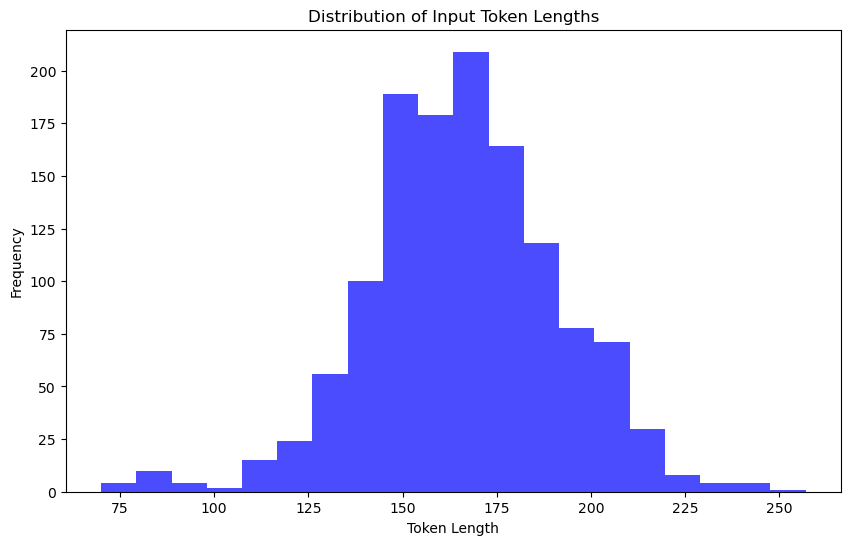

📊 Max token length: 257
📊 Average token length: 166.1
🎯 Using max length: 257 tokens


In [14]:
# Get maximum length and visualize distribution
max_length = plot_data_lengths(tokenized_train_dataset, tokenized_validation_dataset)

# Alternative: Direct calculation of max length
# max_length = max([len(x["input_ids"]) for x in tokenized_train_dataset])
print(f"🎯 Using max length: {max_length} tokens")

### Configure Tokenizer with Padding
Now we'll set up padding to ensure all inputs are the same length:

In [15]:
# Reconfigure tokenizer with padding
tokenizer = AutoTokenizer.from_pretrained(
    model_id,
    padding_side="right",
    add_eos_token=True,
    add_bos_token=True
)
tokenizer.pad_token = tokenizer.eos_token    # Use EOS token as pad token

print(f"✅ Tokenizer configured with padding to {max_length} tokens")

✅ Tokenizer configured with padding to 257 tokens


In [16]:
# Updated tokenization function with padding
def tokenize(prompt):
    result = tokenizer(
        prompt,
        truncation=True,
        max_length=max_length,
        padding="max_length"
    )
    result["labels"] = result["input_ids"].copy()
    return result

# Re-tokenize datasets with padding
print("🔄 Re-tokenizing datasets with padding...")
tokenized_train_dataset = train_set.map(generate_and_tokenize_prompt)
tokenized_validation_dataset = validation_set.map(generate_and_tokenize_prompt)
print("✅ Padded tokenization complete!")

🔄 Re-tokenizing datasets with padding...


Map:   0%|          | 0/141 [00:00<?, ? examples/s]

✅ Padded tokenization complete!


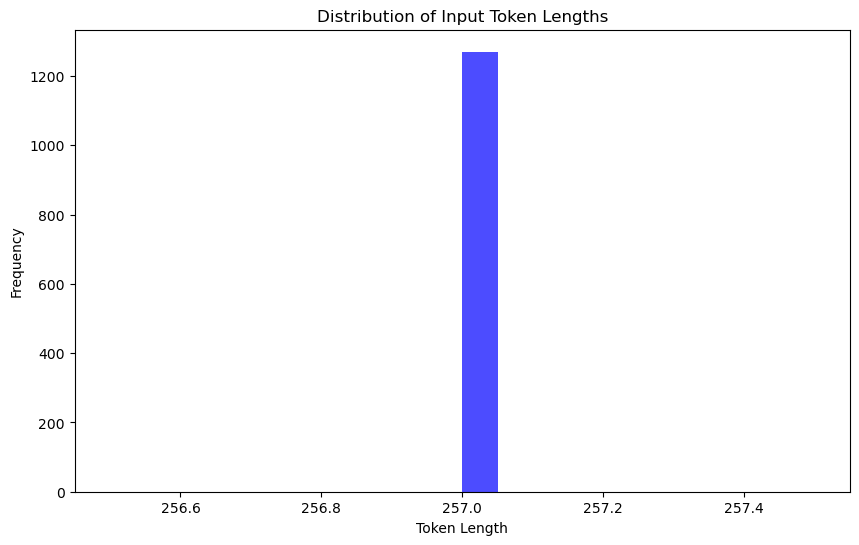

📊 Max token length: 257
📊 Average token length: 257.0


257

In [17]:
# Verify all tokens are now the same length
plot_data_lengths(tokenized_train_dataset, tokenized_validation_dataset)

## Step 6: Configure QLoRA (Quantized LoRA)

In [18]:
# Prepare model for QLoRA fine-tuning
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)
print("✅ Model prepared for training!")

✅ Model prepared for training!


In [19]:
# Helper function to check trainable parameters
def print_trainable_parameters(model):
    """Prints the number of trainable parameters in the model."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(f"🔢 Trainable params: {trainable_params:,}")
    print(f"🔢 All params: {all_param:,}")
    print(f"📊 Trainable%: {100 * trainable_params / all_param:.2f}%")

In [20]:
# Check current trainable parameters (should be 0)
print("📋 Before QLoRA:")
print_trainable_parameters(model)

📋 Before QLoRA:
🔢 Trainable params: 0
🔢 All params: 12,457,497,600
📊 Trainable%: 0.00%


In [21]:
print(model) # optional, you can check the full architecture of the model

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(131072, 5120)
    (layers): ModuleList(
      (0-39): 40 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear4bit(in_features=5120, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=5120, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=5120, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=5120, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=5120, out_features=32768, bias=False)
          (up_proj): Linear4bit(in_features=5120, out_features=32768, bias=False)
          (down_proj): Linear4bit(in_features=32768, out_features=5120, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm((5120,), eps=1e-05)
        (post_attention_layernorm): MistralRMSN

In [22]:
# Configure LoRA adapters
from peft import LoraConfig, get_peft_model

print("🎯 Setting up LoRA configuration...")
target_modules = ["q_proj", "k_proj"]

config = LoraConfig(
    r=8,                        # Rank of adaptation
    lora_alpha=32,              # LoRA scaling parameter
    target_modules=target_modules, 
    lora_dropout=0.05,          # Dropout probability for LoRA layers
    bias="none",                # Bias configuration
    task_type="CAUSAL_LM"       # Task type
)

# Apply LoRA to model
model = get_peft_model(model, config)
print("✅ LoRA adapters added!")

🎯 Setting up LoRA configuration...
✅ LoRA adapters added!


In [23]:
# Check trainable parameters after adding LoRA
print("📋 After QLoRA:")
print_trainable_parameters(model)
# print(model) # optional, you can check the full architecture of the model

📋 After QLoRA:
🔢 Trainable params: 4,915,200
🔢 All params: 12,462,412,800
📊 Trainable%: 0.04%


## Step 7: Fine-tuning Configuration & Training

In [27]:
# Enable model parallelism if multiple GPUs available
dev_count = torch.cuda.device_count()
print(f"🖥️ Available GPUs: {dev_count}")

if dev_count > 1:
    model.is_parallelizable = True
    model.model_parallel = True
    print("✅ Model parallelism enabled!")

🖥️ Available GPUs: 1


In [28]:
# Training configuration
import transformers

# Set up logging directory
log_bucket = "./logs/medical-qlora-training"

# Configure training arguments
training_args = transformers.TrainingArguments(
    per_device_train_batch_size=4,      # Batch size per device
    per_device_eval_batch_size=4,       # Evaluation batch size
    max_steps=100,                      # Total training steps
    output_dir="mistral-medical-outputs",  # Output directory
    logging_dir=log_bucket,             # Logging directory
    logging_steps=10,                   # Log every N steps
    learning_rate=5e-6,                 # Learning rate
    fp16=True,                          # Mixed precision training
    save_strategy="steps",              # Save strategy
    save_steps=100,                     # Save every N steps
    eval_strategy="steps",              # Evaluation strategy
    eval_steps=50,                      # Evaluate every N steps
    do_eval=True,                       # Enable evaluation
    warmup_steps=10,                    # Warmup steps
    gradient_checkpointing=True,        # Memory optimization
    gradient_accumulation_steps=4,      # Gradient accumulation
    optim="paged_adamw_8bit",          # Optimizer
    report_to="tensorboard",           # Logging platform
    weight_decay=0.05                   # Regularization
)

print("✅ Training configuration complete!")

✅ Training configuration complete!


In [29]:
# Initialize trainer

tokenizer.pad_token = tokenizer.eos_token

trainer = transformers.Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_validation_dataset,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)

# Disable caching for training
model.config.use_cache = False

print("✅ Trainer ready!")

max_steps is given, it will override any value given in num_train_epochs


✅ Trainer ready!


<mark>‼️ Please skip to section "Download fine-tuned model from Hugging Face" if you are in the workshop session.</mark>

In [ ]:
# Start training!
print("🚀 Starting training...")
print("⏱️ This will take approximately a few hours on ml.g5.12xlarge for 300 traninng steps")

# Uncomment the next line to start training. 
# trainer.train()

## Step 8: Prepare Model for Amazon Bedrock Custom Model Import

In [ ]:
# Skip this step in workshop 
from transformers import AutoModelForCausalLM
from peft import PeftModel

model_id = "mistralai/Mistral-Small-24B-Instruct-2501"
adapter_path = "mistral-medical-outputs/checkpoint-300"

# Load base model in full precision (FP16), not quantised 4bit model
base_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map="auto",
    cache_dir="/mnt/sagemaker-nvme"
)

In [11]:
# Skip this step in workshop 
# Load fine-tuned model (with adapter)
ft_model = PeftModel.from_pretrained(
    base_model,
    adapter_path,
)

In [ ]:
# Merge LoRA weights into the base model
merged_model = ft_model.merge_and_unload()

# Save as FP16 (recommended for Bedrock)
merged_model.save_pretrained("finetune_results/merged_model", safe_serialization=True)

In [ ]:
## optional: push your fine-tuned model to huggingface hub
# from transformers import AutoTokenizer

# tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-Small-24B-Instruct-2501")  # e.g., same tokenizer used during fine-tuning

# # Push merged weights
# merged_model.push_to_hub("<user_name>/mistral-small-3-med", use_temp_dir=False)

# # Push tokenizer files too
# tokenizer.push_to_hub("<user_name>/mistral-small-3-med", use_temp_dir=False)


### Download fine-tuned model from huggingface hub for the workshop

In [ ]:
from huggingface_hub import snapshot_download

folder = snapshot_download(repo_id="lowkeymaverick/Mistral-Small-24B-Instruct-2501-finetuned", local_dir="fine-tuned-model")
print("Model repo saved to:", folder)


### Upload model files to S3 bucket for CMI

In [ ]:
import os
import boto3

# Configuration
local_dir = "fine-tuned-model"
bucket_name = "<BUCKET_NAME>" # output from the cloudformation stack
prefix = "workshop"  

# Initialize S3 client
s3_client = boto3.client('s3')

# Upload fine-tuned model to S3 bucket 
for root, dirs, files in os.walk(local_dir):
    for file in files:
        local_path = os.path.join(root, file)
        # Compute relative path to preserve folder structure in S3
        relative_path = os.path.relpath(local_path, local_dir)
        s3_key = f"{prefix}/{relative_path}" if prefix else relative_path

        print(f"Uploading to s3://{bucket_name}/{s3_key}...")
        s3_client.upload_file(
            Filename=local_path,
            Bucket=bucket_name,
            Key=s3_key
        )
        print(f"Successfully transferred {local_path} to s3://{bucket_name}/{s3_key}")

### Create a CMI job 

In [ ]:
import boto3
import datetime
from sagemaker import get_execution_role


client = boto3.client("bedrock", region_name="us-west-2")

# Define your S3 model path and IAM role ARN

s3_uri = f"s3://{bucket_name}/{prefix}/mistral-small-instruct-24b-finetuned/cmi/"
role_arn = "<BedrockImportRole>"  # output from the cloudformation stack


# Create the import job
response = client.create_model_import_job(
    jobName = f"mistral-small-3-import-{datetime.datetime.now():%Y%m%d%H%M%S}",
    importedModelName = "mistral-small-3-workshop",
    roleArn = role_arn,
    modelDataSource = {
        "s3DataSource": {
            "s3Uri": s3_uri
        }
    },
)

In [ ]:
import time
job_id = response["jobArn"]
while True:
    res = client.get_model_import_job(jobIdentifier=job_id)
    status = res["status"]
    print("Status:", status)
    if status in ["Completed", "Failed"]:
        break
    time.sleep(30)
if status == "Completed":
    print("Imported model ARN:", res["importedModelArn"])
else:
    print("Failure reason:", res.get("failureMessage"))

## Step 9: Evaluate Model Performance

### Test mistral small 3.0 model before fine-tune

In [33]:
prompt = test_set[20]['Prompt']
prompt

'A 60-year-old male with a history of smoking and hypertension presents with sudden onset chest pain radiating to the left arm. His ECG shows ST-segment elevation in leads II, III, and aVF. What could be the diagnosis and the next steps?'

In [34]:
groundthruth= test_set[20]['Completion']
groundthruth

"The patient's symptoms and ECG findings suggest ST-segment elevation myocardial infarction (STEMI), specifically involving the inferior wall of the heart. This is a type of acute coronary syndrome (ACS) and is a medical emergency. The patient should receive aspirin and be prepared for immediate reperfusion therapy, preferably primary percutaneous coronary intervention (PCI), if available and if there are no contraindications."

### Mistral Small 3.0 before fine-tune 

In [35]:
# Initialize Bedrock client
bedrock = boto3.client('bedrock-runtime', region_name='us-west-2')
base_model_id = "<MISTRAL_SMALL_ENDPOINT_ARN>"
## replace with your mistral small 3 endpoint ARN from the first notebook


result_before = bedrock.converse(
  modelId=base_model_id,
  messages=[
      {
          "role": "user",
          "content": [{"text": prompt}]
      }
  ],
  inferenceConfig={
      "maxTokens": 1000,
      "temperature": 0.3,
      "topP": 0.9,
      "stopSequences": ["###prompt", "### prompt"]
  }
)

print(result_before['output']['message']['content'][0]['text'])

Based on the information provided, the diagnosis is likely an **inferior wall ST-elevation myocardial infarction (STEMI)**. Here's why:

- **Symptoms**: Sudden onset chest pain radiating to the left arm is a classic symptom of myocardial infarction.
- **Risk Factors**: The patient's history of smoking and hypertension are significant risk factors for coronary artery disease.
- **ECG Findings**: ST-segment elevation in leads II, III, and aVF is indicative of an inferior wall STEMI.

### Next Steps:

1. **Immediate Management**:
   - **Activate the Catheterization Lab**: If available, immediate percutaneous coronary intervention (PCI) is the preferred treatment for STEMI.
   - **Administer Aspirin**: 162-325 mg chewed and swallowed.
   - **Administer P2Y12 Inhibitor**: Such as clopidogrel (300-600 mg loading dose) or ticagrelor (180 mg loading dose).
   - **Administer Anticoagulant**: Such as unfractionated heparin or bivalirudin.
   - **Administer Oxygen**: If the patient is hypoxic.
  

### Mistral Small 3.0 after fine-tune with medical dataset

In [39]:
import json
import boto3
from botocore.config import Config
fine_tuned_model_id = res["importedModelArn"]

# handle "Model is not ready for inference" error 
config = Config(
    retries={
        'total_max_attempts': 10, 
        'mode': 'standard'
    }
)

session = boto3.session.Session()
bedrock = session.client(service_name = 'bedrock-runtime', config=config)

# Build the inference payload according to model's request format
payload = {
    "prompt": prompt,
    "temperature": 0.3,
    "max_tokens": 1000,
    "top_p": 0.9,
    "stop": ["\n###"]
}

try:
    response = bedrock.invoke_model(
        modelId=fine_tuned_model_id,
        body=json.dumps(payload),
        contentType="application/json",
    )
    # Parse and display the output
    model_output = json.loads(response["body"].read())
    result_after = model_output["outputs"][0]['text']
    
    resp_prefix = "### completion:"
    if result_after.startswith(resp_prefix):
        result_after = result_after[len(resp_prefix):].strip()
    
    print(result_after)
except Exception as e:
    print(e)
    print(e.__repr__())

The patient's symptoms and ECG findings are suggestive of an inferior wall ST-segment elevation myocardial infarction (STEMI), likely due to occlusion of the right coronary artery. Immediate management should include administration of aspirin, sublingual nitroglycerin, oxygen if hypoxic, and initiation of reperfusion strategy, either through thrombolytic therapy or emergent cardiac catheterization if available.


## 🎉 Workshop Complete!

You've successfully learned how to:

### ✅ What You've Accomplished:
1. **Set up** QLoRA fine-tuning environment
2. **Loaded** and preprocessed medical training data
3. **Configured** Mistral Small 24B with 4-bit quantization
4. **Applied** LoRA adapters for efficient training
5. **Understood** model preparation for Bedrock deployment

### 🚀 Next Steps:
- **Run the training**: Uncomment `trainer.train()` to start fine-tuning
- **Test your model**: Compare base vs fine-tuned performance
- **Deploy to Bedrock**: Use Custom Model Import for production

### 📚 Additional Resources:
- [Amazon Bedrock Custom Model Import](https://docs.aws.amazon.com/bedrock/latest/userguide/model-customization-import-model.html)
- [PEFT LoRA Documentation](https://huggingface.co/docs/peft/main/en/conceptual_guides/lora)
- [Mistral AI Documentation](https://docs.mistral.ai/)